In [2]:
import torch

# Working with datasets 

Following [the tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html),
we start with the vision datasets that come with PyTorch.

In [3]:
from torchvision import datasets

We load the fashionMINST dataset. This can be done by the `FashionMINST` class, 
which automatically downloads the data for us. 
The `ToTensor` class is callable: 
the `FashionMINST` object will feed pictures in the dataset to an instance of this class,
so that each picture then is transformed into a tensor. 

In [4]:
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    # Where the data are stored. If this is a relative path, 
    # the path is assumed to start from the current working directory. 
    # Therefore you can find a data folder coming together with this notebook.
    root="data",  
    # Let the dataset contains training data only.
    train=True, 
    download=True,
    transform=ToTensor()
)

Similarly the test dataset is downloaded and transformed.

In [5]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We can play with `training_data` for a while to see how it works with other parts of the Torch ecosystem.
We can run several tests:

In [6]:
print(iter(training_data))
print(len(training_data))
print(type(training_data[1]))
print(type(training_data[1][0]), type(training_data[1][1]))
print(training_data[1][0].size())
print(len(training_data[1][0]))

60000
<class 'tuple'>
<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])
1


Clearly, a `FashionMINST` object is iterable and has a definite length.
Each item in the object - according to `__getitem__` - 
is a tuple, the first member of which is a tenser and the second member of which is an integer.
In short, `FashionMINST` is designed to look like a list of data-label pairs.
The size of the data part of a data-label pair is `[1, 28, 28]`:
the first dimension seems to be the channel (there is only one of it in FashionMINST)
and the second and third dimensions seem to be the x and y coordinates.
`len(tensor)` gives its *first* dimension - not the total number of elements in it.

The meanings of the labels are given below. Besides, we can plot some of the tensors.

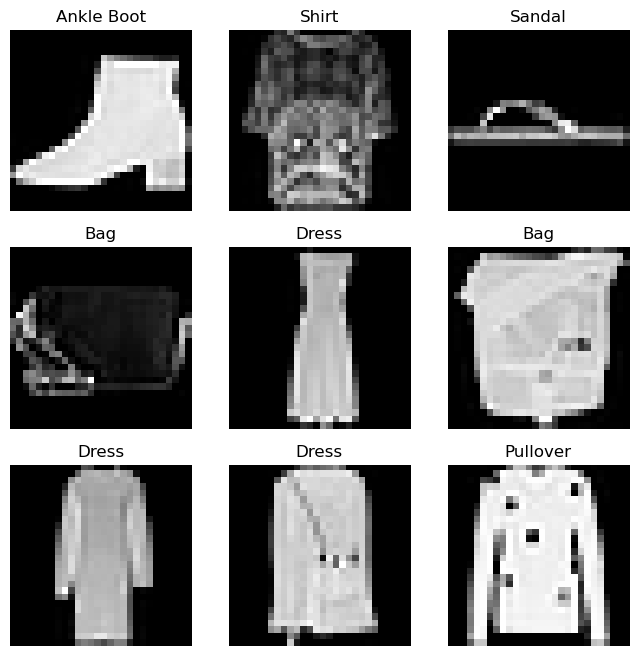

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
row = 3
col = 3
# Don't forget that in Python, a `range` doesn't include the upper limit
for i in range(1, row * col + 1): 
    # This line is a good demonstration of how Torch tensors work.
    # `randint` is a multiple-dispatched method,
    # and here we are invoking the (int upper_limit, tuple size) version.
    # So basically `torch.randint(len(training_data), (1,))` 
    # is a 1-dimensional tensor containing a random index of `training_data`.
    # Since it's still a tensor, the `item` method is used to flatten it into a scalar, 
    # i.e. a `int`.
    idx = torch.randint(len(training_data), (1,)).item()
    # The data-label pair
    img, label = training_data[idx]
    figure.add_subplot(row, col, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # Here the `squeeze` method removes the extra channel dimension  
    plt.imshow(img.squeeze(), cmap="grey")

We have now seen how a dataset works.
The next question is how to feed a dataset to a model,
because modern neural networks are usually trained batch-by-batch.
`DataLoader` is a class for this purpose.

In [8]:
from torch.utils.data import DataLoader

batch_size = 64

training_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader     = DataLoader(test_data,     batch_size=batch_size)

We can peak into the internal structure of a batch in a dataloader.
It can be seen that the index corresponding to the position in a batch 
doesn't receive any special treatment: 
it just appears as the first index.
This is of course related to the tensor passing convention of a Torch model:
the first several dimensions are assumed to be batch sizes.
Therefore to pass a single sample to a model, 
we actually need to manually add one dimension to the sample!

In [8]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    # DataLoader is not subscriptable, 
    # so if we only want to see the first batch, 
    # we have to first invoke the interator of the DataLoader  
    # and then stop immediately after one iteration.
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Model architecture

In [9]:
print(torch.cuda.is_available())

True


Since CUDA is available, we set device to CUDA.

In [11]:
device = "cuda"

A Torch neural network model is a subclass of `nn.Module`.
The model we are designing here consists of two components:
a layer that flattens the input, 
and three fully connected ReLU layers.

In [9]:
from torch import nn 
class FashionMINSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flattern = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flattern(x)
        logits = self.linear_relu_stack(x)
        return logits


To create a model just do the follows: 

In [12]:
model = FashionMINSTClassifier().to(device)
print(model)

FashionMINSTClassifier(
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


We can play with the model for a while. As you can see, by default we can pass a batch of data to the model, and the model will generate an output for every data point in the batch. 

In [13]:
# .cuda() is necessary: 
# the model now is on GPU and we need to transfer th tensor to GPU as well.
print(model(training_data[0][0].cuda()))

for X, y in test_dataloader:
    print(model(X.to(device))) 
    break

tensor([[ 0.0771,  0.0086,  0.0268, -0.0553, -0.0060,  0.0546,  0.0440,  0.0013,
         -0.0672, -0.0047]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 5.9986e-03, -1.3940e-02,  1.2873e-02, -1.9798e-02,  3.9633e-02,
         -1.4016e-02,  2.2533e-02, -1.1354e-02, -4.2033e-02,  3.9758e-03],
        [-5.9531e-03, -9.4386e-03, -2.3405e-03, -8.8760e-02, -2.5031e-03,
          1.0881e-01,  8.0221e-02, -4.3921e-02,  8.1964e-03,  2.8662e-02],
        [ 1.0786e-02, -1.4384e-02,  1.1449e-02, -4.8409e-02,  3.8514e-02,
          6.1283e-02, -3.5924e-03,  8.5052e-03, -8.3289e-03,  2.2062e-02],
        [ 3.1959e-02, -1.7120e-02, -2.4169e-04, -1.6123e-02,  3.3404e-02,
          3.3836e-02,  1.0604e-02, -5.2190e-03,  1.4302e-03, -1.0086e-03],
        [-4.8233e-03,  2.6300e-03,  2.3337e-02, -2.9654e-02, -4.3302e-02,
          5.6390e-02,  4.3661e-02,  8.1668e-03,  2.3747e-02,  1.1549e-02],
        [-1.5371e-02, -2.1808e-03,  1.7136e-02, -5.0572e-02,  1.1490e-02,
          7.2093e-02, -3.901

# Training

Most loss functions and optimizers are already included in Torch installation.
Here `lr` is the learning rate. 

In [14]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
     
    loss_Xy = loss(model(X), y)

    print(loss_Xy) 
    print(loss_Xy.backward())

    break

tensor(2.3151, device='cuda:0', grad_fn=<NllLossBackward0>)
None


In [16]:
def train(model, dataloader, loss, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        loss_Xy = loss(model(X), y)
        
        # Backpropagation. 
        # Note that PyTorch automatically records what steps are taken when evaluating a tensor,
        # and therefore we don't take the derivative of the model 
        #- we take the derivative of the tensor instead.
        # When a gradient is calculated, 
        # it's stored in model.parameters.grad,
        # so the optimizer will know it without us explicitly passing the gradient to the optimizer.
        loss_Xy.backward()
        optimizer.step() 
        # Note that if two backpropagations are done, 
        # what is stored in model.parameters.grad will accumulate.
        # Therefore we ask the optimizer to clear this variable.
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss_Xy = loss_Xy.item()
            current_sample = len(X) * (batch + 1) # What's the last data point
            print(f"loss: {loss_Xy:>7f} [{current_sample:>5d} / {size:>5d}]")

In [17]:
def test(model, dataloader, loss):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    model.eval()

    test_loss = 0.0
    accuracy = 0.0

    # Temporarily disables gradient.
    # This will speed up inference.
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss_Xy = loss(pred, y)
            test_loss += loss_Xy.item()
            # Here argmax(1) means doing argmax in dimension 1; 
            # that's to say, pred.argmax(1) gives the index of the most likely label 
            # for each data point in the batch; 
            # that's why pred.argmax(1) has the same dimension as y.
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batch
    accuracy /= size
    
    print(f"Test accuracy: {accuracy:>7f}  average loss: {test_loss:>7f}")

In [18]:
epoches = 5
for epoch in range(epoches):
    print(f"Epoch {epoch+1:>3d} ------------")
    train(model, training_dataloader, loss, optimizer)
    test(model, test_dataloader, loss)

Epoch   1 ------------
loss: 2.313552 [   64 / 60000]
loss: 2.298446 [ 6464 / 60000]


loss: 2.279375 [12864 / 60000]
loss: 2.272877 [19264 / 60000]
loss: 2.255646 [25664 / 60000]
loss: 2.222878 [32064 / 60000]
loss: 2.227440 [38464 / 60000]
loss: 2.191794 [44864 / 60000]
loss: 2.194582 [51264 / 60000]
loss: 2.157769 [57664 / 60000]
Test accuracy: 0.401700  average loss: 2.153309
Epoch   2 ------------
loss: 2.166662 [   64 / 60000]
loss: 2.155594 [ 6464 / 60000]
loss: 2.097268 [12864 / 60000]
loss: 2.111876 [19264 / 60000]
loss: 2.062121 [25664 / 60000]
loss: 1.995582 [32064 / 60000]
loss: 2.021315 [38464 / 60000]
loss: 1.939084 [44864 / 60000]
loss: 1.952016 [51264 / 60000]
loss: 1.871786 [57664 / 60000]
Test accuracy: 0.517200  average loss: 1.874734
Epoch   3 ------------
loss: 1.912825 [   64 / 60000]
loss: 1.879857 [ 6464 / 60000]
loss: 1.762523 [12864 / 60000]
loss: 1.802823 [19264 / 60000]
loss: 1.693137 [25664 / 60000]
loss: 1.640487 [32064 / 60000]
loss: 1.659865 [38464 / 60000]
loss: 1.560654 [44864 / 60000]
loss: 1.594884 [51264 / 60000]
loss: 1.486084 [57664

# Saving, loading, using model

Now that the training process is completed, we see how to save and load models, and how to use them.

In [20]:
torch.save(model.state_dict(), "relu-stack.pth")
print("Model saved.")

Model saved.


Let's now destroy the old `model` variable and replace it with what is loaded from `relu-stack.pth`.

In [13]:
model = FashionMINSTClassifier().to(device)
model.load_state_dict(torch.load("relu-stack.pth"))

<All keys matched successfully>

Now we can do inference tasks.

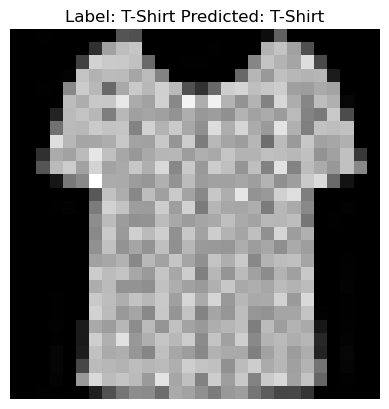

In [16]:
model.eval()

def display(idx):
    x, y = test_data[idx] 
    x = x.squeeze()  # Remove the useless channel dimension

    with torch.no_grad():
        # PyTorch models only accept samples in batches;
        # a dummy batch dimension is created by unsqueeze to achieve this.
        y_pred = model(x.unsqueeze(0).to(device)).argmax().item()

    label_true = labels_map[y]
    label_pred = labels_map[y_pred]
    
    plt.figure()
    plt.title(f"Label: {label_true} Predicted: {label_pred}")
    plt.axis("off")
    plt.imshow(x, cmap="gray")

display(1000)

Let's then learn from some failed predictions.

In [17]:
for idx in range(len(test_data)):
    x, y = test_data[idx] 
    x = x.squeeze()  # Remove the useless channel dimension

    with torch.no_grad():
        # PyTorch models only accept samples in batches;
        # a dummy batch dimension is created by unsqueeze to achieve this.
        y_pred = model(x.unsqueeze(0).to(device)).argmax().item()

    if y_pred != y:
        print(idx)

7
8
10
11
17
21
23
25
26
27
37
40
42
43
44
45
48
50
51
52
53
54
63
66
68
73
74
79
82
84
87
89
90
92
98
101
103
106
111
114
117
135
138
139
147
149
151
153
154
155
167
171
172
175
176
182
183
190
193
202
209
216
217
219
221
222
226
227
236
239
240
241
244
246
249
252
253
254
255
257
261
265
269
271
273
282
285
286
289
290
292
293
294
295
299
302
306
309
312
313
316
318
322
325
332
344
353
354
357
359
363
369
370
378
379
380
381
382
384
387
389
390
393
397
404
406
407
409
411
415
418
419
420
421
423
425
430
432
434
437
441
444
445
448
449
454
457
459
460
461
465
476
478
480
484
485
490
491
499
502
503
506
510
511
516
524
531
532
535
542
544
546
548
552
559
561
562
563
564
565
567
569
570
572
578
581
586
587
588
589
590
592
594
595
596
602
607
612
616
618
623
627
628
633
634
635
637
638
639
641
654
655
657
658
661
663
664
670
674
676
678
681
684
685
686
688
693
695
696
701
705
711
716
722
724
725
726
729
732
733
734
735
737
743
745
747
750
753
758
760
761
764
765
767
774
775
785
787
788
7

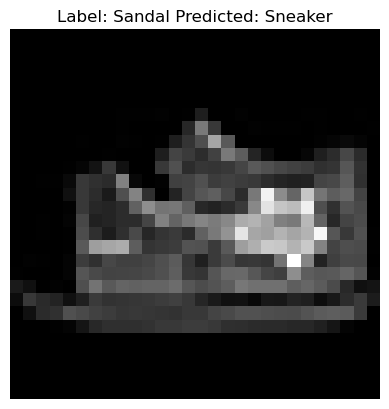

In [21]:
display(9999)